# Imports


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from time import time
from torchvision import transforms

from pytorch_model_summary import summary

import random
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA

import pandas as pd
import glob
import os
import imageio
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Loading DATASET

In [3]:
ATTRIBUTES_PATH = "lfw_attributes.txt"
DATASET_PATH ="lfw-deepfunneled/lfw-deepfunneled/"

dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(5)

,person,path
0,Raul_Cubas,lfw-deepfunneled/lfw-deepfunneled/Raul_Cubas/R...
1,David_Trimble,lfw-deepfunneled/lfw-deepfunneled/David_Trimbl...
2,David_Trimble,lfw-deepfunneled/lfw-deepfunneled/David_Trimbl...
3,David_Trimble,lfw-deepfunneled/lfw-deepfunneled/David_Trimbl...
4,David_Trimble,lfw-deepfunneled/lfw-deepfunneled/David_Trimbl...


In [4]:
def fetch_dataset(dx=50, dy=50, dimx=128, dimy=128):
    
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"
    
    all_photos = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [5]:
cut = 50 # Remove pixels of background from the sides

SHAPE = 128 #Must be multiple of 16
LATENT_DIMS = 64
SH = SHAPE // 8 # Used to construct the VAE

data, attrs = fetch_dataset(dx = cut, dy = cut, dimx = SHAPE, dimy = SHAPE)
data = np.array(data / 255, dtype='float32').transpose((0, 3, 1, 2))

# Loading Model

In [7]:
from model import VariationalAutoencoder
from train_aux import plot_gallery

# Model Instantiation
LATENT_DIMS = 64

device = 'cuda:0'
model = VariationalAutoencoder(latents=LATENT_DIMS).to(device)

print(summary(model, torch.zeros((1, *data.shape[1:])).to(device), show_input=True))

model.load_state_dict(torch.load("weights/finalModel.pt"))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
     EncoderConv-1     [1, 3, 128, 128]       1,086,454       1,086,454
     DecoderConv-2              [1, 64]         560,651         560,651
Total params: 1,647,105
Trainable params: 1,647,105
Non-trainable params: 0
------------------------------------------------------------------------


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


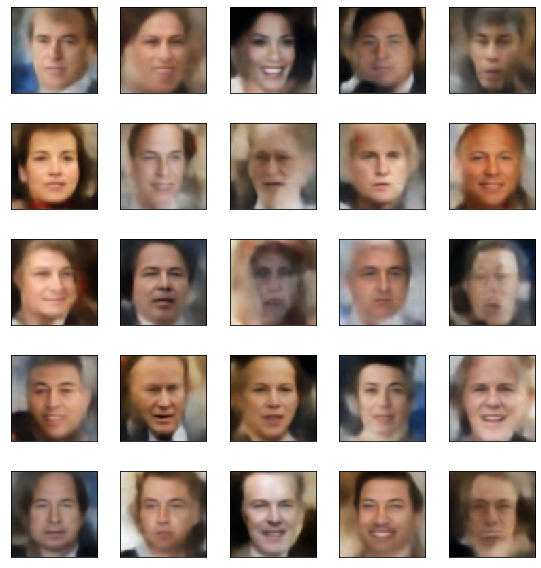

In [8]:
z = np.random.randn(25, LATENT_DIMS)

with torch.no_grad():
    inputs = torch.FloatTensor(z)    
    inputs = inputs.to(device)
    model.eval()
    output = model.decoder(inputs)
    plot_gallery(output.data.cpu().numpy(), n_row=5, n_col=5)

# Trying some features

In [9]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(25).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(25).index.values
sunglasses_data = data[sunglasses_ids]

def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic)
        inputs = inputs.to(device)
        model.eval()
        mean, sd = model.encoder(inputs)        
        return mean

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(device)
        model.eval()
        output = model.decoder(inputs)        
        return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


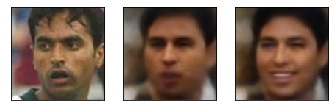

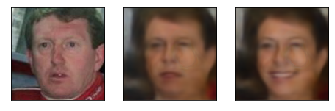

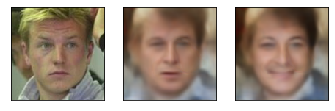

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


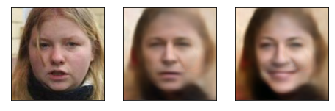

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


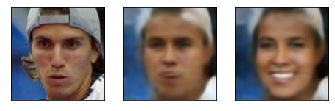

In [10]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)
sunglasses_latent = to_latent(sunglasses_data).mean(axis=0)

smile_vec = smile_latent-no_smile_latent

def make_me_smile(ids):
    for id in ids:
        pic = data[id:id+1]
        encoded = model(torch.tensor(pic).to(device))[0].cpu().detach().numpy()[0]
        latent_vec = to_latent(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.cpu().numpy()
        plot_gallery([pic[0], encoded, pic_output[0]], n_row=1, n_col=3)

make_me_smile(no_smile_ids[:5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


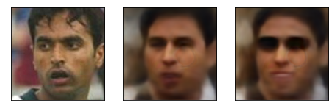

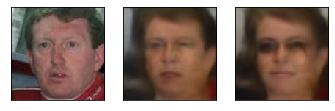

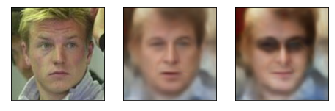

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


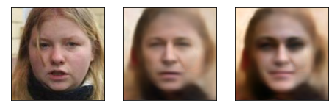

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


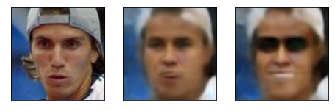

In [11]:
sunglasses_vec = sunglasses_latent - no_smile_latent

def give_me_sunglasses(ids):
    for id in ids:        
        pic = data[id:id+1]
        encoded = model(torch.tensor(pic).to(device))[0].cpu().detach().numpy()[0]
        latent_vec = to_latent(pic)
        latent_vec[0] += sunglasses_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.cpu().numpy()
        plot_gallery([pic[0],encoded, pic_output[0]], n_row=1, n_col=3)
        
give_me_sunglasses(no_smile_ids[:5])

# Geodesics

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 127.5, 127.5, -0.5)

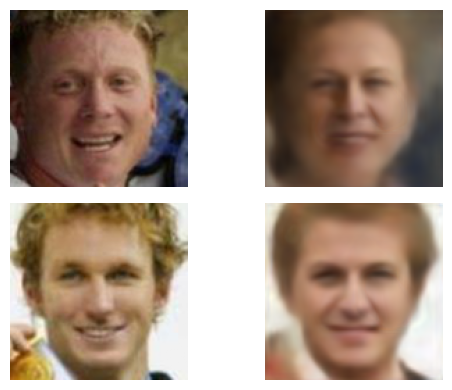

In [67]:
model = model.to('cuda:0')

images = data[:4,:,:,:]
images = torch.tensor(images).to(device)

with torch.no_grad():
    out = model(images)[0]

plt.figure(dpi=100, tight_layout=True)
plt.subplot(2,2,1)
plt.imshow(images[1].cpu().numpy().transpose([1,2,0]))
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(out[1].cpu().numpy().transpose([1,2,0]))
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(images[3].cpu().numpy().transpose([1,2,0]))
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(out[3].cpu().numpy().transpose([1,2,0]))
plt.axis('off')

In [114]:
from stochman import manifold, geodesic, utilities
from stochman.curves import BasicCurve, CubicSpline

class geoDecoder(manifold.EmbeddedManifold):
    def __init__(self, decoder, **kwargs):
        super(geoDecoder).__init__(**kwargs)
        self.decoder = decoder

    def embed(self, points): # works for only 1 image in batch
        #print('Curve points shape', points.shape)
        B = points.shape[0]
        N = points.shape[1]
        decode = self.decoder(points[0])
        #print('After decoder shape', decode.shape)
        decode = decode.reshape([B, N, -1])
        #print('After reshaping shape', decode.shape)
        return decode
    
    #def embed(self, points, jacobian=False):
    #    decode =  torch.cat([torch.reshape(self.decoder(points[idx]), (points.shape[0], -1)).unsqueeze(0) for idx in range(points.shape[0])], 0)
    #    print(decode.shape)
    #    return decode

In [115]:
model = model.to('cpu')
model.eval()

geom = geoDecoder(decoder = model.decoder)

X = images.cpu()
mu, log_var = model.encoder(X)
z  = torch.normal(mu, torch.exp(0.5*log_var)).cpu()

In [116]:
#print('Points shape', sample[1].shape)

curve, success = geom.connecting_geodesic(z[1], z[3])

print('Success?', success)

RuntimeError: shape '[8192, 32, 16, 16]' is invalid for input of size 8192

(1, 11, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


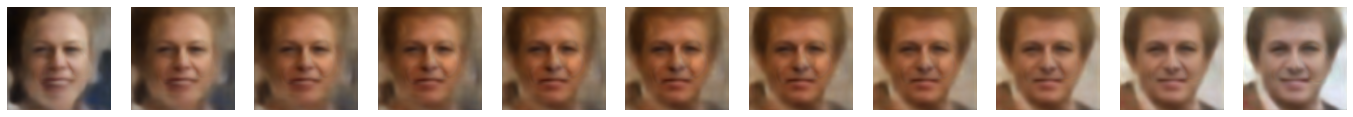

In [104]:
a = torch.cat([torch.ones(1,1)*i/10 for i in range(11)], axis=1)
cp = curve.forward(a)

B, N, L = cp.shape

print(f"({B}, {N}, {L})")

# Generating Images corroponding to every geodesic.

img_along_geod = np.zeros([N, 3, 128, 128])

# Plotting Images along each geodesic. [Left to Right]

fig, ax = plt.subplots(1, N, figsize=(24, 12))
for i in range(N):
    img_along_geod[i] = geom.decoder(cp[0][i:i+1]).detach().numpy()
    ax[i].imshow(img_along_geod[i].transpose([1,2,0]), vmin = 0, vmax = 1)
    ax[i].axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


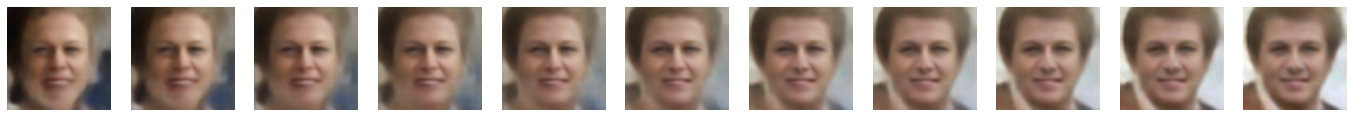

In [105]:
with torch.no_grad():
    dif = z[3] - z[1]

    line = np.zeros_like(cp.detach())
    for i in range(0, cp.shape[1]):
        line[:,i,:] = z[1] + i * dif / (cp.shape[1]-1)

line = torch.tensor(line)
img_along_line = np.zeros([N, 3, 128, 128])

# Plotting Images along each geodesic. [Left to Right]

fig, ax = plt.subplots(1, N, figsize=(24, 12))
for i in range(N):
    img_along_line[i] = geom.decoder(line[0][i:i+1]).detach().numpy()
    ax[i].imshow(img_along_line[i].transpose([1,2,0]), vmin = 0, vmax = 1)
    ax[i].axis('off')
plt.show()

# Visualizing

In [106]:
# Visualizing Latent Space

def plot_manfold(model, data, N, N_sample=3, geodesics=None, linear = None, device="cpu", algo="pca", func="linear"):
    """
    Args:
    - model: Trained Model
    - N: No of Images
    - N_sample: No. of Sample per Image
    - data: Dataloader
    - algo: PCA/Fast-ICA
    - func: Act as Kernel for PCA and G-Function for ICA.
            for PCA: {linear, poly, rbf, sigmoid, cosine}
            for ICA: {logcosh, exp, cube}
    """

    # Put model on cpu
    model = model.to(device)

    # Sampling Images
    idx = np.random.randint(0, data.shape[0], N)
    X = torch.tensor(data[idx])

    # Forward Pass through Encoder
    mu_, _log_var = model.encoder(X.float())

    # Sampling from Normal Disitrbution using predicted Parameters
    embeddings = torch.vstack([torch.normal(mu_, 0.5*torch.exp(_log_var)) for _ in range(N_sample)]).detach().cpu().numpy()

    # Dimensionality Reduction
    dim_red = None
    low_dim_embeddings = None
    if algo == "pca":
        dim_red = KernelPCA(n_components=2, kernel=func)
        low_dim_embeddings = dim_red.fit_transform(embeddings)
    else:
        dim_red = FastICA(n_components=2, fun=func)
        low_dim_embeddings = dim_red.fit_transform(embeddings)
    
    # Free Memory
    del X, embeddings

    # Plotting Principle Components
    plt.figure(figsize=(16,8))
    plt.scatter(x = low_dim_embeddings[:,0], 
                y = low_dim_embeddings[:, 1], 
                alpha=0.6)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    if geodesics is not None:
        colors = ["red", "green", "orange", "black", "cyan", "magenta", "lime", "brown", "gray", "teal", "chocolate"]
        for i in range(geodesics.shape[0]):
            gdscs = dim_red.transform(geodesics[i].detach().numpy())
            plt.plot(gdscs[:,0], 
                     gdscs[:, 1],
                     color=colors[i],
                     linewidth=4)
            
    if linear is not None:
        colors = ["red", "green", "orange", "black", "cyan", "magenta", "lime", "brown", "gray", "teal", "chocolate"][::-1]
        for i in range(geodesics.shape[0]):
            gdscs = dim_red.transform(linear[i].detach().numpy())
            plt.plot(gdscs[:,0], 
                     gdscs[:, 1],
                     color=colors[i],
                     linewidth=4)

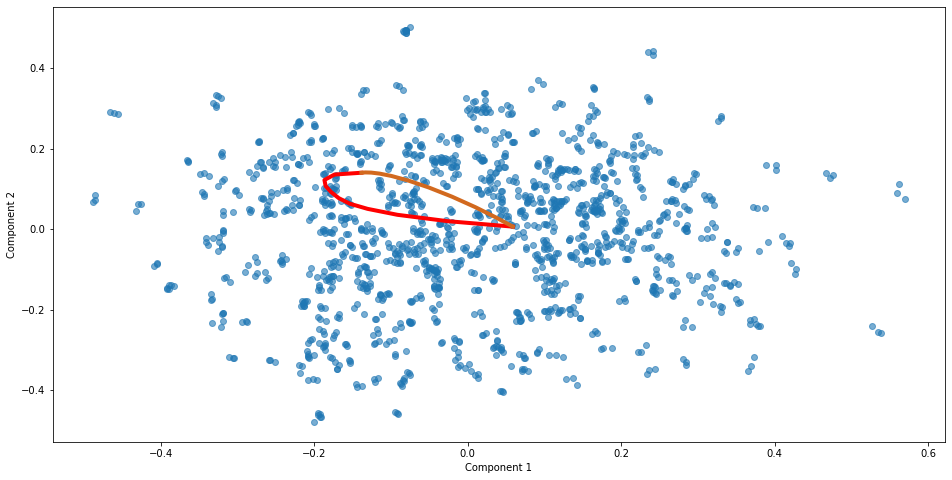

In [107]:
plot_manfold(model, data, 500, 3, geodesics=cp, linear = line, device="cpu", algo="pca", func="cosine")